### 2019 Data Science Bowl

#### Description and Challenge of the project
<br> https://www.kaggle.com/c/data-science-bowl-2019/overview
<br> In this project game analytics data for kids given by PBS KIDS. In this app kids can play
<br> games, watch clips and perform different activities and after some game session they are assigned 
<br> test.Kids can take multiple tests or single test or many records for kids with no test.
<br> If they cam solve test correctly in single attempt then their accuracy group is 3, if two attempt
<br> to solve correctly then accuracy group is 2, if multiple atempts then 1 if could not solve then 0.
<br> Dataset is hierchical. For every apps installed, one installation id is assigned. We can consider
<br> one kid has one installation id (assuming no shared device). One kid can play multiple game sessions
<br> and one game session might have multiple events. Some of the variables like activity types, title, world
<br> etc. are in game session level and some event related variables are at lower level.
<br> Target variable is accuracy group.
<br> The challenge is in train data accuracy group is at game session level
<br> but we have to predict in test data at installation id level, in higher level.
<br> Moreover only 1000 test records are given but Kaggle is measuring accuracy on 8 MM records.

#### Approach for this notebook
<br> Feature engineering is done using inetrmedate panda data frame.
<br> For training data , assessment game sessions identified and extracted some features.
<br> Then a look up table is created to capture all activities before assessment.
<br> Here assumption is that activities before  assessment will impact accuracy.
<br> After that , different features created mainly number of activities and game time.
<br> Irrelevent features are excluded before model building. 
<br> Different models and hyperparameter tuning performed.
<br> XGBoost and Deep Learning in Keras framework presented here.
<br> Same feature extraction strategy applied to test data primrily but did not go very well.
<br> For test data similar approach but at installation id levels features extraction performed.
<br> Final scores measured using Cohen-Kappa score.

##### Importing Required modules and load data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot
from time import time
from collections import Counter
import datetime
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import gc
import json
pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_ind='local'

if path_ind=='kaggle':
    file_path="/kaggle/input/data-science-bowl-2019"
else:
    file_path="/Users/krishanubanerjee/Downloads/data-science-bowl-2019"
    

train=pd.read_csv(file_path+"/train.csv")
train_labels=pd.read_csv(file_path+"/train_labels.csv")
test=pd.read_csv(file_path+"/test.csv")
sample_submission=pd.read_csv(file_path+"/sample_submission.csv")

##### Feature Engineering for Train Test

In [3]:
def acc_grp_calc(x):
    """
    This function will assign accuracy to accuracy group
    """
    if x==0:
        return(0)
    elif x==1:
        return(3)
    elif x==0.5:
        return(2)
    else:
        return(1)

In [4]:
def get_assessment_df(input_flg):
    """
    This function will identify assessment for train or test and create some related features
    from different assessments and related titles. This function will also derive fetures from 
    multiple assessment takers cumulatively
    """
    assert ((input_flg == 'train') | (input_flg == 'test')),"Input is not train or test"
    if input_flg=='train':
        df_ass=train[train['type']=='Assessment']\
             [((train['event_code']==4100)&(train['title']!='Bird Measurer (Assessment)'))\
             |((train['event_code']==4110)&(train['title']=='Bird Measurer (Assessment)'))]
    else:
        df_ass=test[test['type']=='Assessment']
        
    df_ass['correct_attempt']=np.where(df_ass['event_data'].str.contains('true'),1,0)
    df_ass['incorrect_attempt']=np.where(df_ass['event_data'].str.contains('false'),1,0)
    df_ass=df_ass.groupby(['installation_id','game_session','title']).agg({'correct_attempt':'sum',\
                                                          'incorrect_attempt':'sum'}).reset_index()
    df_ass['accuracy']=np.where(df_ass['correct_attempt']+df_ass['incorrect_attempt']==0,0,\
             round(df_ass['correct_attempt']/(df_ass['correct_attempt']+df_ass['incorrect_attempt']),1))
    df_ass['accuracy_group']=df_ass['accuracy'].apply(lambda x:acc_grp_calc(x))
    df_ass['accumulated_correct']=df_ass.groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['accumulated_incorrect']=df_ass.groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    # correct and incorrect attempt by type of assessment
    df_ass['Mushroom_sorter_correct']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Mushroom_sorter_incorrect']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Bird_Measurer_correct']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Bird_Measurer_incorrect']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cauldron_Filler_correct']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cauldron_Filler_incorrect']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cart_Balancer_correct']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cart_Balancer_incorrect']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Chest_Sorter_correct']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Chest_Sorter_incorrect']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass=df_ass.drop(['title'],axis=1)
    #  Cumulative accuracy group
    df_ass['accuracy_0']=np.where(df_ass['accuracy_group']==0,1,0)
    df_ass['accuracy_0']=df_ass.groupby('installation_id').agg({'accuracy_0':np.cumsum})
    df_ass['accuracy_1']=np.where(df_ass['accuracy_group']==1,1,0)
    df_ass['accuracy_1']=df_ass.groupby('installation_id').agg({'accuracy_1':np.cumsum})
    df_ass['accuracy_2']=np.where(df_ass['accuracy_group']==2,1,0)
    df_ass['accuracy_2']=df_ass.groupby('installation_id').agg({'accuracy_2':np.cumsum})
    df_ass['accuracy_3']=np.where(df_ass['accuracy_group']==3,1,0)
    df_ass['accuracy_3']=df_ass.groupby('installation_id').agg({'accuracy_3':np.cumsum})
    
    
    df_ass['cumcnt']=df_ass.groupby('installation_id').cumcount()
    df_ass=df_ass.drop(['correct_attempt','incorrect_attempt','accuracy'],axis=1)

    df_ass=df_ass.fillna(0)
    if input_flg=='train':
        df_ass=df_ass.drop(['cumcnt'],axis=1)
    else:
        df_ass=df_ass.drop(['cumcnt','accuracy_group'],axis=1)
    return(df_ass)

In [5]:
def get_assessment_test_df(input_flg):
    """
    This function will get assessment for Test and extract related features
    """
    assert (input_flg == 'test'),"Input is not test"
    df_ass=test[test['type']=='Assessment']   
    df_ass['correct_attempt']=np.where(df_ass['event_data'].str.contains('true'),1,0)
    df_ass['incorrect_attempt']=np.where(df_ass['event_data'].str.contains('false'),1,0)
    df_ass=df_ass.groupby(['installation_id','title']).agg({'correct_attempt':'sum',\
                                                          'incorrect_attempt':'sum'}).reset_index()
    df_ass['accuracy']=np.where(df_ass['correct_attempt']+df_ass['incorrect_attempt']==0,0,\
             round(df_ass['correct_attempt']/(df_ass['correct_attempt']+df_ass['incorrect_attempt']),1))
    df_ass['accuracy_group']=df_ass['accuracy'].apply(lambda x:acc_grp_calc(x)) 
    df_ass['accumulated_correct']=df_ass.groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['accumulated_incorrect']=df_ass.groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    # correct and incorrect attempt by type of assessment
    df_ass['Mushroom_sorter_correct']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Mushroom_sorter_incorrect']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Bird_Measurer_correct']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Bird_Measurer_incorrect']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cauldron_Filler_correct']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cauldron_Filler_incorrect']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cart_Balancer_correct']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cart_Balancer_incorrect']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Chest_Sorter_correct']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Chest_Sorter_incorrect']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    #  Cumulative accuracy group
    df_ass['accuracy_0']=np.where(df_ass['accuracy_group']==0,1,0)
    df_ass['accuracy_0']=df_ass.groupby('installation_id').agg({'accuracy_0':np.cumsum})
    df_ass['accuracy_1']=np.where(df_ass['accuracy_group']==1,1,0)
    df_ass['accuracy_1']=df_ass.groupby('installation_id').agg({'accuracy_1':np.cumsum})
    df_ass['accuracy_2']=np.where(df_ass['accuracy_group']==2,1,0)
    df_ass['accuracy_2']=df_ass.groupby('installation_id').agg({'accuracy_2':np.cumsum})
    df_ass['accuracy_3']=np.where(df_ass['accuracy_group']==3,1,0)
    df_ass['accuracy_3']=df_ass.groupby('installation_id').agg({'accuracy_3':np.cumsum})
    
    df_ass=df_ass.drop(['correct_attempt','incorrect_attempt','accuracy','accuracy_group','title'],axis=1)
    df_ass=df_ass.groupby(['installation_id']).agg({k:'sum' for k in df_ass.columns if k!='installation_id' }).reset_index()

    df_ass=df_ass.fillna(0)
    return(df_ass)

In [6]:
def get_subset_tm_event_cnt(df_input):
    """
    This function will create features for maximum event and game time for all game sessions
    """
    subset_tm_cnt=df_input.groupby(['installation_id','game_session'])\
                                    .agg({'game_time':['max'],\
                                          'event_count':['max']}).reset_index()
    subset_tm_cnt.columns=['installation_id','game_session','gm_tm_max','evnt_max']
    subset_tm_cnt=subset_tm_cnt.fillna(0)

    return(subset_tm_cnt)

In [7]:
def get_subset_tm_event_cnt_test(df_input):
    """
    Extract average game time and event featires for test specific
    """
    subset_tm_cnt=df_input.groupby(['installation_id','game_session'])\
                                    .agg({'game_time':['max'],\
                                          'event_count':['max']}).reset_index()
    subset_tm_cnt.columns=['installation_id','game_session','gm_tm_max','evnt_max']
    subset_tm_cnt=subset_tm_cnt.fillna(0)
    subset_tm_cnt=subset_tm_cnt.groupby(['installation_id'])\
                            .agg({'gm_tm_max':['max','mean','std'],'evnt_max':['max','mean','std']}).reset_index()
    return(subset_tm_cnt)

In [8]:
def lkp_sessons_bfr_assignement(df_input,df_ass):
    """
    Look up for train to identify all game sessions before assessment.
    This will be used for other feature extraction
    """

    df_exp=df_input[['timestamp','game_session','installation_id']]
    df_exp=df_exp.groupby(['game_session','installation_id']).agg({'timestamp':'max'}).reset_index()

    df_gm_ass=df_exp[(df_exp['installation_id'].isin(list(df_ass['installation_id'].unique())))&\
                    (df_exp['game_session'].isin(list(df_ass['game_session'].unique())))]
    df_gm_ass=df_gm_ass.rename(columns={"game_session": "target_game_session", "timestamp": "target_timestamp"})
    df_gm_ass['order']=df_gm_ass.sort_values('target_timestamp').groupby('installation_id').cumcount()
    df_gm_ass_max=df_gm_ass.groupby(['installation_id']).agg({'target_timestamp':'max'}).reset_index()
    
    df_lkp=pd.merge(df_exp,df_gm_ass_max,left_on='installation_id',right_on='installation_id')
    df_lkp=df_lkp[df_lkp['timestamp']<=df_lkp['target_timestamp']]
    df_lkp=df_lkp.drop(['target_timestamp'],axis=1)
    df_lkp=pd.merge(df_lkp,df_gm_ass,left_on=['installation_id','game_session'],
                     right_on=['installation_id','target_game_session'],how='left')\
                        .sort_values(by=['installation_id','timestamp'])
    df_lkp['target_game_session']=df_lkp['target_game_session'].fillna(method='bfill')
    df_lkp['order']=df_lkp['order'].fillna(method='bfill').astype(int)
    df_lkp=df_lkp.drop(['timestamp','target_timestamp'],axis=1)
    return(df_lkp)

In [9]:
def get_avg_gm_tm_event_cnt(tm_event_cnt,df_lkp):
    """
    Get average event and game related features
    """
    df_avg_tm_event_cnt=pd.merge(tm_event_cnt,df_lkp,on=['installation_id','game_session'])
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.drop(['game_session'],axis=1)
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.groupby(['installation_id','target_game_session'])\
                        .agg({'gm_tm_max':['max','mean','std'],'evnt_max':['max','mean','std']}).reset_index()
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.rename(columns={"target_game_session": "game_session"})
    return(df_avg_tm_event_cnt)

In [10]:
def get_event_history_data(df_input,df_lkp,val):
    """
    Activity history by installation id,game session
    """ 
    df_subset=df_input[['installation_id','game_session',val]]
    df_subset=df_subset.groupby(['installation_id','game_session',val]).agg({val:'count'})
    df_subset=df_subset.rename(columns={val:'total'}).reset_index()
    df_subset[val]=df_subset[val].astype(str)

    df_pivot=df_subset.pivot_table(index=['installation_id','game_session'],columns=val,values='total').reset_index()
    df_pivot=df_pivot.fillna(0)
    
    train_col=[str(x) for x in list(df_pivot.columns) if x not in ['installation_id','game_session']]
    df_pivot=pd.merge(df_pivot,df_lkp,on=['installation_id','game_session'])
    df_pivot=df_pivot.drop(['game_session'],axis=1)
    df_pivot=df_pivot.groupby(['installation_id','target_game_session','order'])\
                            .agg({i:'sum' for i in train_col }).reset_index()
    df_pivot=df_pivot.rename(columns={"target_game_session": "game_session"})
    for i in train_col:
        df_pivot[str('cumcnt_')+i]=df_pivot.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})
    df_pivot=df_pivot.drop(list(set(train_col)|{'order'}),axis=1)
    return(df_pivot)

In [11]:
def get_event_history_data_test(df_input,val):
    """
    Activity history for test at installation id level
    """
    df_subset=df_input[['installation_id',val]]
    df_subset=df_subset.groupby(['installation_id',val]).agg({val:'count'})
    df_subset=df_subset.rename(columns={val:'total'}).reset_index()
    df_subset[val]=df_subset[val].astype(str)
    df_pivot=df_subset.pivot_table(index=['installation_id'],columns=val,values='total').reset_index()
    df_pivot=df_pivot.fillna(0)
    df_pivot=df_pivot.rename(columns={k:str('cumcnt_')+str(k) for k in \
                                      list(df_pivot.columns) if k !='installation_id'})
    return(df_pivot)

In [12]:
def get_activity_history(df_input,df_lkp,tm_event_cnt):
    """
    This function will get activity history-number of attempt and time spend for title,type and world
    """
    df_subset=df_input[['installation_id','game_session','title','type','world']]
    df_subset=df_subset.drop_duplicates()
    df_subset=pd.merge(df_subset,df_lkp,on=['installation_id','game_session'])
    df_subset_act=df_subset.drop(['game_session'],axis=1)
    df_subset_act=df_subset_act.rename(columns={"target_game_session": "game_session"})
    
    def get_category_cnt(val):
        """
        Aggregate and pivot for attempts for variables
        """
        df=df_subset_act.groupby(['installation_id','game_session','order',val]).agg({val:'count'})
        df=df.rename(columns={val:'total'}).reset_index()
        df=df.pivot_table(index=['installation_id','game_session','order'],\
                          columns=val,values=['total']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
        for i in train_col:
            df[str('cumcnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})
            
        df=df.drop(list(set(train_col)|{'order'}),axis=1)
        #df=df.rename(columns={'cnt_installation_id':'installation_id','cnt_game_session':'game_session'})
        return(df)
    
    df_type=get_category_cnt('type')
    df_world=get_category_cnt('world')
    df_activity=pd.merge(df_world,df_type,on=['installation_id','game_session'])
    
    
    # activity time
    df_subset_gm_tm=pd.merge(df_subset,tm_event_cnt,on=['installation_id','game_session'])
    df_subset_gm_tm=df_subset_gm_tm.drop(['evnt_max','game_session'],axis=1)
    df_subset_gm_tm=df_subset_gm_tm.rename(columns={"target_game_session": "game_session"})
    
    def get_category_tm(val):
        """
        Aggregate and pivot game time
        """
        df=df_subset_gm_tm.groupby(['installation_id','game_session','order',val]).agg({'gm_tm_max':'mean'})
        df=df.rename(columns={val:'gm_tm_max'}).reset_index()
        df['gm_tm_max']=round(df['gm_tm_max']/1000,0)
        df=df.pivot_table(index=['installation_id','game_session','order'],\
                        columns=val,values=['gm_tm_max']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
        for i in train_col:
            df[str('cum_gm_tm_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

        df=df.drop(list(set(train_col)|{'order'}),axis=1)
        #df=df.rename(columns={'tm_installation_id':'installation_id','tm_game_session':'game_session'})
        return(df)
    
    title_gm=get_category_tm('title')
    type_gm=get_category_tm('type')
    world_gm=get_category_tm('world')
    
    df_tm=pd.merge(title_gm,type_gm,on=['installation_id','game_session'])
    df_tm=pd.merge(df_tm,world_gm,on=['installation_id','game_session'])
    df_activity=pd.merge(df_activity,df_tm,on=['installation_id','game_session'])
    return(df_activity)
    

In [27]:
def get_activity_history_test(df_input,tm_event_cnt):
    """
    This function will get activity history-number of attempt and time spend for title,type and world
    at installation id level for test
    """
    df_subset=df_input[['installation_id','game_session','title','type','world']]
    df_subset=df_subset.drop_duplicates()
    def get_category_cnt(val):
        """
        Aggregate and pivot for attemts at installation id level
        """
        df=df_subset.groupby(['installation_id',val]).agg({val:'count'})
        df=df.rename(columns={val:'total'}).reset_index()
        df=df.pivot_table(index=['installation_id'],\
                              columns=val,values=['total']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        df=df.rename(columns={k:str('cumcnt_')+str(k) for k in list(df.columns) if k !='installation_id'})
        return(df)
    
    df_title=get_category_cnt('title')
    df_type=get_category_cnt('type')
    df_world=get_category_cnt('world')
    df_activity=pd.merge(df_title,df_type,on=['installation_id'])
    df_activity=pd.merge(df_activity,df_type,on=['installation_id'])

    # activity time
    df_subset_gm_tm=pd.merge(df_subset,tm_event_cnt,on=['installation_id','game_session'])
    df_subset_gm_tm=df_subset_gm_tm.drop(['evnt_max','game_session'],axis=1)

    def get_category_tm(val):
        """
        Aggregate and pivot game time at installation id level
        """
        df=df_subset_gm_tm.groupby(['installation_id',val]).agg({'gm_tm_max':'mean'})
        df=df.rename(columns={val:'gm_tm_max'}).reset_index()
        df['gm_tm_max']=round(df['gm_tm_max']/1000,0)
        df=df.pivot_table(index=['installation_id'],columns=val,values=['gm_tm_max']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        df=df.rename(columns={k:str('cum_gm_tm_')+str(k) for k in list(df.columns) if k !='installation_id'})
        return(df)

    title_gm=get_category_tm('title')
    type_gm=get_category_tm('type')
    world_gm=get_category_tm('world')

    df_tm=pd.merge(title_gm,type_gm,on=['installation_id'])
    df_tm=pd.merge(df_tm,world_gm,on=['installation_id'])
    df_activity=pd.merge(df_activity,df_tm,on=['installation_id'])
    return(df_activity)

    

In [14]:
def title_event_code_cnt(df_input,df_lkp):
    """
    Extract a combined feature for title and event code and aggregated per assessment
    """
    df=df_input[['installation_id','game_session','event_code','title']]
    df['title_event_code']=df['event_code'].astype(str)+str('_')+df['title'].astype(str)
    df=df.drop(['event_code','title'],axis=1)
    df=pd.merge(df,df_lkp,on=['installation_id','game_session'])
    df=df.drop(['game_session'],axis=1)
    df=df.rename(columns={"target_game_session": "game_session"})
    df=df.groupby(['installation_id','game_session','order','title_event_code']).agg({'title_event_code':'size'})
    df=df.rename(columns={'title_event_code':'title_event_code_cnt'}).reset_index()
    df=df.pivot_table(index=['installation_id','game_session','order'],\
                        columns='title_event_code',values=['title_event_code_cnt']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
    for i in train_col:
        df[str('cm_cnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

    df=df.drop(list(set(train_col)|{'order'}),axis=1)
    return(df)

In [15]:
def title_event_code_cnt_test(df_input):
    """
    Extract a combined feature for title and event code and aggregated per installation id
    """
    df=df_input[['installation_id','event_code','title']]
    df['title_event_code']=df['event_code'].astype(str)+str('_')+df['title'].astype(str)
    df=df.drop(['event_code','title'],axis=1)
    df=df.groupby(['installation_id','title_event_code']).agg({'title_event_code':'size'})
    df=df.rename(columns={'title_event_code':'title_event_code_cnt'}).reset_index()
    df=df.pivot_table(index=['installation_id'],\
                        columns='title_event_code',values=['title_event_code_cnt']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    df=df.rename(columns={k:str('cm_cnt_')+str(k) for k in list(df.columns) if k !='installation_id'})
    return(df)

In [16]:
def get_modified_title_cumcnt(df_input,df_lkp):
    """
    Need to extract cumulative title count 
    """
    df_subset=df_input[['installation_id','game_session','title']]
    df_subset=pd.merge(df_subset,df_lkp,on=['installation_id','game_session'])
    df_subset_act=df_subset.drop(['game_session'],axis=1)
    df_subset_act=df_subset_act.rename(columns={"target_game_session": "game_session"})
    df=df_subset_act.groupby(['installation_id','game_session','order','title']).agg({'title':'count'})
    df=df.rename(columns={'title':'total'}).reset_index()
    df=df.pivot_table(index=['installation_id','game_session','order'],\
                  columns='title',values=['total']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
    for i in train_col:
        df[str('cumcnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

    df=df.drop(list(set(train_col)|{'order'}),axis=1)
    return(df)

In [17]:
def get_train(df_input,input_flg):
    """
    Merge then all together and get train data
    """
    df_ass=get_assessment_df(input_flg)
    df_lkp=lkp_sessons_bfr_assignement(df_input,df_ass)
    tm_event_cnt=get_subset_tm_event_cnt(df_input)
    avg_tm_event_cnt=get_avg_gm_tm_event_cnt(tm_event_cnt,df_lkp)
    df_event_id=get_event_history_data(df_input,df_lkp,'event_id')
    df_event_code=get_event_history_data(df_input,df_lkp,'event_code')
    df_activity=get_activity_history(df_input,df_lkp,tm_event_cnt)
    df_title_event_code=title_event_code_cnt(df_input,df_lkp)
    df_mod_title=get_modified_title_cumcnt(df_input,df_lkp)
    df=pd.merge(df_ass,avg_tm_event_cnt,on=['installation_id','game_session'])
    df=pd.merge(df,df_event_code,on=['installation_id','game_session'])
    df=pd.merge(df,df_event_id,on=['installation_id','game_session'])
    df=pd.merge(df,df_activity,on=['installation_id','game_session'])
    df=pd.merge(df,df_title_event_code,on=['installation_id','game_session'])
    df=pd.merge(df,df_mod_title,on=['installation_id','game_session'])
    return(df)

In [33]:
%%time
df_train=get_train(train,'train')

CPU times: user 2min 41s, sys: 1min 8s, total: 3min 50s
Wall time: 4min 3s


In [23]:
df_train.shape

(17690, 952)

In [28]:
def get_test(df_input,input_flg):
    """
    Merge then all together and get test data
    """
    df_ass=get_assessment_test_df(input_flg)
    tm_event_cnt=get_subset_tm_event_cnt(df_input)
    avg_tm_event_cnt=get_subset_tm_event_cnt_test(df_input)
    df_event_id=get_event_history_data_test(df_input,'event_id')
    df_event_code=get_event_history_data_test(df_input,'event_code')
    df_activity=get_activity_history_test(df_input,tm_event_cnt)
    df_title_event_code=title_event_code_cnt_test(df_input)
    df=pd.merge(df_ass,avg_tm_event_cnt,on=['installation_id'])
    df=pd.merge(df,df_event_code,on=['installation_id'])
    df=pd.merge(df,df_event_id,on=['installation_id'])
    df=pd.merge(df,df_activity,on=['installation_id'])
    df=pd.merge(df,df_title_event_code,on=['installation_id'])
    return(df)

In [30]:
%%time
df_test=get_test(test,'test')
print(df_test.shape)

(1000, 918)
CPU times: user 3.2 s, sys: 473 ms, total: 3.67 s
Wall time: 3.69 s


In [247]:
def remove_insignificant_features(df_train,df_test):
    """
    This function will drop features not in test, Remove highly corelated features
    and exclude if mean of a feature for train/test > 10 or < 1/10 otherwise scale
    """
    ajusted_test=df_test.copy()
    # Remove all features in train but not in test
    train_features=list(set(list(df_train.columns))-set(['installation_id','game_session','accuracy_group']))
    test_features=list(set(list(df_test.columns))-set(['installation_id']))
    to_drop_other=list(set(test_features)-set(train_features))
    test_features=list(set(test_features)-set(to_drop_other))
    to_drop=list(set(train_features)-set(test_features))
    train_features=list(set(train_features)-set(to_drop))
    to_reduce=[]
    
    for feat_a in train_features:
        for feat_b in train_features:
            if feat_a != feat_b and feat_a not in to_reduce and feat_b not in to_reduce:
                c = np.corrcoef(df_train[feat_a], df_train[feat_b])[0][1]
                if c > 0.995:
                    to_reduce.append(feat_b)
    train_features=list(set(train_features)-set(to_reduce))
    
    to_exclude=[]
    for feature in train_features:
        if (df_train[feature].mean()==0)|(df_test[feature].mean()==0) :
            to_exclude.append(feature)
        else:
            train_mean = df_train[feature].mean()
            test_mean = ajusted_test[feature].mean()
            ajust_factor = train_mean / test_mean
            if (ajust_factor >10)|(ajust_factor <.1):
                to_exclude.append(feature)
            else: 
                ajusted_test[feature] *= ajust_factor
            
    final_features=list(set(train_features)-set(to_exclude))
    train_features=list(set(final_features)|(set(['installation_id','game_session','accuracy_group'])))
    test_features=list(set(final_features)|(set(['installation_id'])))
    
    reduce_train=df_train[train_features]
    ajusted_test=df_test[test_features]
    return(reduce_train,ajusted_test)

In [248]:
reduce_train,ajusted_test=remove_insignificant_features(df_train,df_test)

In [249]:
print(reduce_train.shape)
print(ajusted_test.shape)

(17690, 372)
(1000, 370)


In [250]:
reduce_train=reduce_train.fillna(0)
ajusted_test=ajusted_test.fillna(0)

#### Prepare for model 

In [251]:
reduce_train=reduce_train.set_index(['installation_id','game_session'])
ajusted_test=ajusted_test.set_index(['installation_id'])

In [123]:
indices=reduce_train.index.values
test_indices=ajusted_test.index.values
labels = np.array(reduce_train['accuracy_group'])
features= reduce_train.drop(['accuracy_group'], axis = 1)
features = np.array(features)

In [124]:
from sklearn import preprocessing
train_features, test_features, train_labels, test_labels,idx_train,idx_test = \
            train_test_split(features, labels,indices, test_size = 0.2, random_state = 7)

#### XGBoost Random Grid Search with cross validation
<br>  As XGboost is very expensive , instead of extensive grid search 
<br> we are doing random grid search here

In [132]:
# Parameters for searching best model
params = {
        'min_child_weight': [3,5],
        'subsample': [0.85],
        'max_depth': [8,12,15]
        }
xgb = XGBRegressor(learning_rate=0.001, n_estimators=3000, objective='reg:squarederror',silent=True, nthread=4)

In [133]:
%%time
folds = 5
param_comb = 3

Y = train_labels
X = train_features

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, \
                    n_iter=param_comb, scoring='r2', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )
random_search.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 141.4min finished


CPU times: user 50min 17s, sys: 10.1 s, total: 50min 27s
Wall time: 2h 34min 46s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x161e0a350>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.001, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=3000,
                                          n_jobs...
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                  

In [134]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=12, min_child_weight=5, missing=None, n_estimators=3000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.85, verbosity=1)

 Best normalized gini score for 5-fold search with 3 parameter combinations:
0.7486032789123291

 Best hyperparameters:
{'subsample': 0.85, 'min_child_weight': 5, 'max_depth': 12}


#### Prediction through best model 

In [125]:
%%time
xgb_model=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.25,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=3, missing=None, n_estimators=2000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)
xgb_model.fit(train_features,train_labels)

CPU times: user 35min 28s, sys: 8 s, total: 35min 36s
Wall time: 9min 33s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.25,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=3, missing=None, n_estimators=2000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

#### Converting regression to classification with similar distribution

{0: 0.7594748440672956, 1: 1.6066137255080482, 2: 2.167111396789551}
0.9381205841950103


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12486a690>]],
      dtype=object)

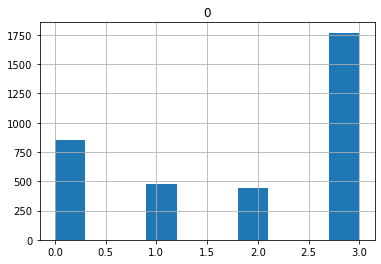

In [126]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(xgb_model.predict(test_features))
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
print(cohen_kappa_score(test_class, test_labels, weights = 'quadratic'))
pd.DataFrame(list(test_class)).hist()

In [127]:
df_top_feature_importance=pd.DataFrame(zip(reduce_train.columns,xgb_model.feature_importances_),\
                                       columns=['features','importance'])
df_top_feature_importance.sort_values(by='importance',ascending=False).head(10)

,features,importance
261,cumcnt_abc5811c,0.104694
194,cm_cnt_2000_Sandcastle Builder (Activity),0.096411
8,Bird_Measurer_incorrect,0.057845
86,cm_cnt_2010_Chest Sorter (Assessment),0.041852
195,Chest_Sorter_incorrect,0.038421
106,accumulated_correct,0.025680
209,cum_gm_tm_Crystals Rule,0.022705
89,cm_cnt_3121_Bird Measurer (Assessment),0.020990
251,cumcnt_12 Monkeys,0.019046
163,Cauldron_Filler_incorrect,0.018637


{0: 0.08486233599243898, 1: 0.08896949887275696, 2: 0.5115065276622772}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13988a390>]],
      dtype=object)

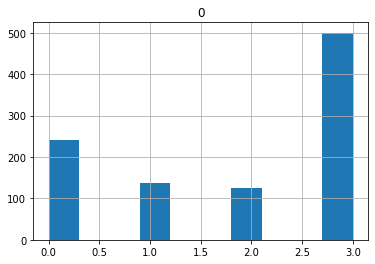

In [128]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(xgb_model.predict(np.array(ajusted_test)))
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
pd.DataFrame(list(test_class)).hist()

##### Conclusion from XGB

<br> Looks like XGB is overfitting becasue there is huge difference between evaluation and test
<br> Feature engineering needs to be done different ways

#### Keras deep learning

<br> With same features will try Keras classification model <br>

In [142]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras.initializers

Using TensorFlow backend.


In [252]:
indices=reduce_train.index.values
test_indices=ajusted_test.index.values
labels = np.array(reduce_train['accuracy_group'])
features= reduce_train.drop(['accuracy_group'], axis = 1)
features = np.array(features)

In [253]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(features)
test_features_scaled=min_max_scaler.fit_transform(np.array(ajusted_test))
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(features_scaled, labels,indices, test_size = 0.2, random_state = 7)

In [292]:
%%time
np.random.seed(12345)
set_random_seed(12345)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(64, activation='relu',\
                input_dim=train_features.shape[1]))
model.add(Dense(32, activation='relu'))
#model.add(Dense(24, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='relu'))
# add output layer
model.add(Dense(4, activation='softmax'))

opt=keras.optimizers.Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="val_loss", patience=40, verbose=10, mode='auto')

one_hot_train_labels = keras.utils.to_categorical(train_labels, num_classes=4)
one_hot_eval_labels = keras.utils.to_categorical(eval_labels, num_classes=4)
# fit model
result = model.fit(train_features, one_hot_train_labels, epochs=2000, batch_size=16,\
                   validation_data=(eval_features, one_hot_eval_labels),callbacks=[earlystopping])
# get predictions
eval_pred = model.predict(eval_features)

test_pred=model.predict(test_features_scaled)

Train on 14152 samples, validate on 3538 samples
Epoch 1/2000
14152/14152 [==============================] - 14s 956us/step - loss: 1.3585 - accuracy: 0.4917 - val_loss: 1.3709 - val_accuracy: 0.4955
Epoch 2/2000
14152/14152 [==============================] - 5s 387us/step - loss: 1.3540 - accuracy: 0.4940 - val_loss: 1.3667 - val_accuracy: 0.4958
Epoch 3/2000
14152/14152 [==============================] - 5s 362us/step - loss: 1.3490 - accuracy: 0.4964 - val_loss: 1.3616 - val_accuracy: 0.4963
Epoch 4/2000
14152/14152 [==============================] - 5s 362us/step - loss: 1.3458 - accuracy: 0.4971 - val_loss: 1.3581 - val_accuracy: 0.4972
Epoch 5/2000
14152/14152 [==============================] - 5s 339us/step - loss: 1.3406 - accuracy: 0.4977 - val_loss: 1.3539 - val_accuracy: 0.4975
Epoch 6/2000
14152/14152 [==============================] - 5s 321us/step - loss: 1.3365 - accuracy: 0.4992 - val_loss: 1.3500 - val_accuracy: 0.4972
Epoch 7/2000
14152/14152 [========================

Epoch 55/2000
14152/14152 [==============================] - 5s 319us/step - loss: 1.2240 - accuracy: 0.5008 - val_loss: 1.2402 - val_accuracy: 0.4972
Epoch 56/2000
14152/14152 [==============================] - 5s 323us/step - loss: 1.2203 - accuracy: 0.5007 - val_loss: 1.2372 - val_accuracy: 0.4972
Epoch 57/2000
14152/14152 [==============================] - 4s 314us/step - loss: 1.2202 - accuracy: 0.5007 - val_loss: 1.2365 - val_accuracy: 0.4972
Epoch 58/2000
14152/14152 [==============================] - 5s 318us/step - loss: 1.2180 - accuracy: 0.5007 - val_loss: 1.2334 - val_accuracy: 0.4972
Epoch 59/2000
14152/14152 [==============================] - 4s 316us/step - loss: 1.2169 - accuracy: 0.5007 - val_loss: 1.2323 - val_accuracy: 0.4972
Epoch 60/2000
14152/14152 [==============================] - 4s 312us/step - loss: 1.2169 - accuracy: 0.5007 - val_loss: 1.2310 - val_accuracy: 0.4972
Epoch 61/2000
14152/14152 [==============================] - 4s 311us/step - loss: 1.2143 - ac

14152/14152 [==============================] - 5s 332us/step - loss: 1.1479 - accuracy: 0.5097 - val_loss: 1.1554 - val_accuracy: 0.5068
Epoch 110/2000
14152/14152 [==============================] - 5s 354us/step - loss: 1.1456 - accuracy: 0.5105 - val_loss: 1.1535 - val_accuracy: 0.5076
Epoch 111/2000
14152/14152 [==============================] - 5s 346us/step - loss: 1.1443 - accuracy: 0.5102 - val_loss: 1.1524 - val_accuracy: 0.5099
Epoch 112/2000
14152/14152 [==============================] - 6s 390us/step - loss: 1.1436 - accuracy: 0.5117 - val_loss: 1.1530 - val_accuracy: 0.5107
Epoch 113/2000
14152/14152 [==============================] - 7s 516us/step - loss: 1.1417 - accuracy: 0.5122 - val_loss: 1.1500 - val_accuracy: 0.5105
Epoch 114/2000
14152/14152 [==============================] - 6s 455us/step - loss: 1.1415 - accuracy: 0.5134 - val_loss: 1.1480 - val_accuracy: 0.5113
Epoch 115/2000
14152/14152 [==============================] - 5s 377us/step - loss: 1.1426 - accuracy: 

Epoch 163/2000
14152/14152 [==============================] - 5s 378us/step - loss: 1.0865 - accuracy: 0.5733 - val_loss: 1.0865 - val_accuracy: 0.5789
Epoch 164/2000
14152/14152 [==============================] - 6s 416us/step - loss: 1.0851 - accuracy: 0.5763 - val_loss: 1.0880 - val_accuracy: 0.5752
Epoch 165/2000
14152/14152 [==============================] - 5s 374us/step - loss: 1.0850 - accuracy: 0.5776 - val_loss: 1.0853 - val_accuracy: 0.5797
Epoch 166/2000
14152/14152 [==============================] - 5s 358us/step - loss: 1.0843 - accuracy: 0.5803 - val_loss: 1.0818 - val_accuracy: 0.5837
Epoch 167/2000
14152/14152 [==============================] - 5s 338us/step - loss: 1.0818 - accuracy: 0.5794 - val_loss: 1.0840 - val_accuracy: 0.5831
Epoch 168/2000
14152/14152 [==============================] - 5s 363us/step - loss: 1.0811 - accuracy: 0.5806 - val_loss: 1.0789 - val_accuracy: 0.5837
Epoch 169/2000
14152/14152 [==============================] - 5s 329us/step - loss: 1.07

Epoch 217/2000
14152/14152 [==============================] - 5s 327us/step - loss: 1.0380 - accuracy: 0.6099 - val_loss: 1.0289 - val_accuracy: 0.6204
Epoch 218/2000
14152/14152 [==============================] - 5s 333us/step - loss: 1.0352 - accuracy: 0.6139 - val_loss: 1.0338 - val_accuracy: 0.6213
Epoch 219/2000
14152/14152 [==============================] - 5s 338us/step - loss: 1.0311 - accuracy: 0.6121 - val_loss: 1.0329 - val_accuracy: 0.6181
Epoch 220/2000
14152/14152 [==============================] - 5s 334us/step - loss: 1.0378 - accuracy: 0.6114 - val_loss: 1.0268 - val_accuracy: 0.6224
Epoch 221/2000
14152/14152 [==============================] - 5s 336us/step - loss: 1.0353 - accuracy: 0.6140 - val_loss: 1.0327 - val_accuracy: 0.6207
Epoch 222/2000
14152/14152 [==============================] - 5s 327us/step - loss: 1.0342 - accuracy: 0.6151 - val_loss: 1.0294 - val_accuracy: 0.6173
Epoch 223/2000
14152/14152 [==============================] - 5s 327us/step - loss: 1.03

Epoch 271/2000
14152/14152 [==============================] - 4s 310us/step - loss: 0.9974 - accuracy: 0.6303 - val_loss: 0.9942 - val_accuracy: 0.6354
Epoch 272/2000
14152/14152 [==============================] - 4s 311us/step - loss: 1.0012 - accuracy: 0.6283 - val_loss: 0.9915 - val_accuracy: 0.6461
Epoch 273/2000
14152/14152 [==============================] - 4s 316us/step - loss: 0.9967 - accuracy: 0.6304 - val_loss: 0.9914 - val_accuracy: 0.6439
Epoch 274/2000
14152/14152 [==============================] - 5s 335us/step - loss: 0.9975 - accuracy: 0.6304 - val_loss: 0.9898 - val_accuracy: 0.6357
Epoch 275/2000
14152/14152 [==============================] - 5s 319us/step - loss: 0.9981 - accuracy: 0.6311 - val_loss: 0.9877 - val_accuracy: 0.6419
Epoch 276/2000
14152/14152 [==============================] - 5s 321us/step - loss: 1.0004 - accuracy: 0.6272 - val_loss: 0.9867 - val_accuracy: 0.6436
Epoch 277/2000
14152/14152 [==============================] - 5s 332us/step - loss: 0.99

Epoch 325/2000
14152/14152 [==============================] - 5s 331us/step - loss: 0.9679 - accuracy: 0.6364 - val_loss: 0.9570 - val_accuracy: 0.6507
Epoch 326/2000
14152/14152 [==============================] - 6s 426us/step - loss: 0.9640 - accuracy: 0.6415 - val_loss: 0.9522 - val_accuracy: 0.6605
Epoch 327/2000
14152/14152 [==============================] - 6s 402us/step - loss: 0.9629 - accuracy: 0.6429 - val_loss: 0.9558 - val_accuracy: 0.6552
Epoch 328/2000
14152/14152 [==============================] - 6s 393us/step - loss: 0.9648 - accuracy: 0.6400 - val_loss: 0.9571 - val_accuracy: 0.6523
Epoch 329/2000
14152/14152 [==============================] - 5s 353us/step - loss: 0.9649 - accuracy: 0.6407 - val_loss: 0.9528 - val_accuracy: 0.6538
Epoch 330/2000
14152/14152 [==============================] - 5s 327us/step - loss: 0.9645 - accuracy: 0.6398 - val_loss: 0.9555 - val_accuracy: 0.6560
Epoch 331/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.96

Epoch 379/2000
14152/14152 [==============================] - 4s 316us/step - loss: 0.9352 - accuracy: 0.6478 - val_loss: 0.9266 - val_accuracy: 0.6668
Epoch 380/2000
14152/14152 [==============================] - 5s 331us/step - loss: 0.9339 - accuracy: 0.6502 - val_loss: 0.9173 - val_accuracy: 0.6699
Epoch 381/2000
14152/14152 [==============================] - 5s 329us/step - loss: 0.9339 - accuracy: 0.6497 - val_loss: 0.9183 - val_accuracy: 0.6702
Epoch 382/2000
14152/14152 [==============================] - 5s 319us/step - loss: 0.9374 - accuracy: 0.6499 - val_loss: 0.9224 - val_accuracy: 0.6696
Epoch 383/2000
14152/14152 [==============================] - 5s 337us/step - loss: 0.9278 - accuracy: 0.6519 - val_loss: 0.9195 - val_accuracy: 0.6665
Epoch 384/2000
14152/14152 [==============================] - 5s 324us/step - loss: 0.9345 - accuracy: 0.6485 - val_loss: 0.9183 - val_accuracy: 0.6673
Epoch 385/2000
14152/14152 [==============================] - 5s 322us/step - loss: 0.93

Epoch 433/2000
14152/14152 [==============================] - 4s 317us/step - loss: 0.9043 - accuracy: 0.6579 - val_loss: 0.8909 - val_accuracy: 0.6772
Epoch 434/2000
14152/14152 [==============================] - 4s 315us/step - loss: 0.9080 - accuracy: 0.6565 - val_loss: 0.8874 - val_accuracy: 0.6806
Epoch 435/2000
14152/14152 [==============================] - 5s 324us/step - loss: 0.9085 - accuracy: 0.6552 - val_loss: 0.8856 - val_accuracy: 0.6764
Epoch 436/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.9032 - accuracy: 0.6596 - val_loss: 0.8819 - val_accuracy: 0.6837
Epoch 437/2000
14152/14152 [==============================] - 4s 310us/step - loss: 0.9031 - accuracy: 0.6593 - val_loss: 0.8888 - val_accuracy: 0.6781
Epoch 438/2000
14152/14152 [==============================] - 4s 309us/step - loss: 0.9087 - accuracy: 0.6572 - val_loss: 0.8872 - val_accuracy: 0.6795
Epoch 439/2000
14152/14152 [==============================] - 4s 310us/step - loss: 0.90

Epoch 487/2000
14152/14152 [==============================] - 4s 312us/step - loss: 0.8798 - accuracy: 0.6649 - val_loss: 0.8637 - val_accuracy: 0.6863
Epoch 488/2000
14152/14152 [==============================] - 4s 311us/step - loss: 0.8856 - accuracy: 0.6592 - val_loss: 0.8607 - val_accuracy: 0.6891
Epoch 489/2000
14152/14152 [==============================] - 4s 313us/step - loss: 0.8839 - accuracy: 0.6598 - val_loss: 0.8623 - val_accuracy: 0.6874
Epoch 490/2000
14152/14152 [==============================] - 4s 312us/step - loss: 0.8793 - accuracy: 0.6618 - val_loss: 0.8540 - val_accuracy: 0.6899
Epoch 491/2000
14152/14152 [==============================] - 4s 311us/step - loss: 0.8821 - accuracy: 0.6620 - val_loss: 0.8597 - val_accuracy: 0.6885
Epoch 492/2000
14152/14152 [==============================] - 4s 317us/step - loss: 0.8851 - accuracy: 0.6615 - val_loss: 0.8595 - val_accuracy: 0.6857
Epoch 493/2000
14152/14152 [==============================] - 4s 311us/step - loss: 0.87

Epoch 541/2000
14152/14152 [==============================] - 5s 358us/step - loss: 0.8539 - accuracy: 0.6687 - val_loss: 0.8367 - val_accuracy: 0.6914
Epoch 542/2000
14152/14152 [==============================] - 5s 324us/step - loss: 0.8596 - accuracy: 0.6661 - val_loss: 0.8409 - val_accuracy: 0.6899
Epoch 543/2000
14152/14152 [==============================] - 5s 321us/step - loss: 0.8550 - accuracy: 0.6704 - val_loss: 0.8372 - val_accuracy: 0.6914
Epoch 544/2000
14152/14152 [==============================] - 5s 335us/step - loss: 0.8654 - accuracy: 0.6663 - val_loss: 0.8373 - val_accuracy: 0.6908
Epoch 545/2000
14152/14152 [==============================] - 5s 329us/step - loss: 0.8577 - accuracy: 0.6684 - val_loss: 0.8307 - val_accuracy: 0.6922
Epoch 546/2000
14152/14152 [==============================] - 5s 335us/step - loss: 0.8579 - accuracy: 0.6689 - val_loss: 0.8358 - val_accuracy: 0.6933
Epoch 547/2000
14152/14152 [==============================] - 5s 327us/step - loss: 0.85

Epoch 595/2000
14152/14152 [==============================] - 5s 320us/step - loss: 0.8402 - accuracy: 0.6716 - val_loss: 0.8131 - val_accuracy: 0.6962
Epoch 596/2000
14152/14152 [==============================] - 4s 318us/step - loss: 0.8359 - accuracy: 0.6740 - val_loss: 0.8208 - val_accuracy: 0.6933
Epoch 597/2000
14152/14152 [==============================] - 4s 313us/step - loss: 0.8317 - accuracy: 0.6757 - val_loss: 0.8159 - val_accuracy: 0.6962
Epoch 598/2000
14152/14152 [==============================] - 4s 312us/step - loss: 0.8332 - accuracy: 0.6749 - val_loss: 0.8139 - val_accuracy: 0.6959
Epoch 599/2000
14152/14152 [==============================] - 5s 370us/step - loss: 0.8327 - accuracy: 0.6778 - val_loss: 0.8173 - val_accuracy: 0.6956
Epoch 600/2000
14152/14152 [==============================] - 5s 376us/step - loss: 0.8325 - accuracy: 0.6751 - val_loss: 0.8201 - val_accuracy: 0.6936
Epoch 601/2000
14152/14152 [==============================] - 5s 347us/step - loss: 0.83

Epoch 649/2000
14152/14152 [==============================] - 5s 336us/step - loss: 0.8115 - accuracy: 0.6791 - val_loss: 0.7948 - val_accuracy: 0.7010
Epoch 650/2000
14152/14152 [==============================] - 5s 341us/step - loss: 0.8174 - accuracy: 0.6803 - val_loss: 0.7948 - val_accuracy: 0.7010
Epoch 651/2000
14152/14152 [==============================] - 5s 326us/step - loss: 0.8152 - accuracy: 0.6800 - val_loss: 0.8004 - val_accuracy: 0.6995
Epoch 652/2000
14152/14152 [==============================] - 5s 346us/step - loss: 0.8151 - accuracy: 0.6787 - val_loss: 0.7962 - val_accuracy: 0.6998
Epoch 653/2000
14152/14152 [==============================] - 5s 327us/step - loss: 0.8162 - accuracy: 0.6767 - val_loss: 0.7929 - val_accuracy: 0.7007
Epoch 654/2000
14152/14152 [==============================] - 5s 326us/step - loss: 0.8188 - accuracy: 0.6794 - val_loss: 0.8053 - val_accuracy: 0.6945
Epoch 655/2000
14152/14152 [==============================] - 4s 313us/step - loss: 0.80

Epoch 703/2000
14152/14152 [==============================] - 5s 349us/step - loss: 0.7987 - accuracy: 0.6870 - val_loss: 0.7863 - val_accuracy: 0.7044
Epoch 704/2000
14152/14152 [==============================] - 5s 336us/step - loss: 0.7976 - accuracy: 0.6860 - val_loss: 0.7795 - val_accuracy: 0.7058
Epoch 705/2000
14152/14152 [==============================] - 5s 339us/step - loss: 0.7968 - accuracy: 0.6856 - val_loss: 0.7773 - val_accuracy: 0.7080
Epoch 706/2000
14152/14152 [==============================] - 5s 377us/step - loss: 0.8017 - accuracy: 0.6859 - val_loss: 0.7737 - val_accuracy: 0.7086
Epoch 707/2000
14152/14152 [==============================] - 5s 354us/step - loss: 0.7910 - accuracy: 0.6886 - val_loss: 0.7801 - val_accuracy: 0.7097
Epoch 708/2000
14152/14152 [==============================] - 6s 400us/step - loss: 0.7910 - accuracy: 0.6873 - val_loss: 0.7780 - val_accuracy: 0.7055
Epoch 709/2000
14152/14152 [==============================] - 5s 330us/step - loss: 0.79

Epoch 757/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.7795 - accuracy: 0.6906 - val_loss: 0.7612 - val_accuracy: 0.7120
Epoch 758/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.7814 - accuracy: 0.6901 - val_loss: 0.7553 - val_accuracy: 0.7114
Epoch 759/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7748 - accuracy: 0.6943 - val_loss: 0.7563 - val_accuracy: 0.7134
Epoch 760/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7807 - accuracy: 0.6912 - val_loss: 0.7602 - val_accuracy: 0.7142
Epoch 761/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7747 - accuracy: 0.6926 - val_loss: 0.7561 - val_accuracy: 0.7157
Epoch 762/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7746 - accuracy: 0.6915 - val_loss: 0.7604 - val_accuracy: 0.7109
Epoch 763/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.78

Epoch 811/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7553 - accuracy: 0.7003 - val_loss: 0.7489 - val_accuracy: 0.7148
Epoch 812/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.7586 - accuracy: 0.6994 - val_loss: 0.7452 - val_accuracy: 0.7140
Epoch 813/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7615 - accuracy: 0.6972 - val_loss: 0.7441 - val_accuracy: 0.7165
Epoch 814/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7571 - accuracy: 0.6983 - val_loss: 0.7425 - val_accuracy: 0.7210
Epoch 815/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7614 - accuracy: 0.6988 - val_loss: 0.7439 - val_accuracy: 0.7162
Epoch 816/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7542 - accuracy: 0.6994 - val_loss: 0.7364 - val_accuracy: 0.7193
Epoch 817/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.76

Epoch 865/2000
14152/14152 [==============================] - 5s 352us/step - loss: 0.7439 - accuracy: 0.7039 - val_loss: 0.7312 - val_accuracy: 0.7182
Epoch 866/2000
14152/14152 [==============================] - 5s 354us/step - loss: 0.7448 - accuracy: 0.7049 - val_loss: 0.7270 - val_accuracy: 0.7213
Epoch 867/2000
14152/14152 [==============================] - 5s 359us/step - loss: 0.7404 - accuracy: 0.7000 - val_loss: 0.7328 - val_accuracy: 0.7159
Epoch 868/2000
14152/14152 [==============================] - 5s 366us/step - loss: 0.7479 - accuracy: 0.7047 - val_loss: 0.7297 - val_accuracy: 0.7222
Epoch 869/2000
14152/14152 [==============================] - 5s 350us/step - loss: 0.7475 - accuracy: 0.7029 - val_loss: 0.7296 - val_accuracy: 0.7196
Epoch 870/2000
14152/14152 [==============================] - 5s 343us/step - loss: 0.7515 - accuracy: 0.6974 - val_loss: 0.7296 - val_accuracy: 0.7168
Epoch 871/2000
14152/14152 [==============================] - 5s 343us/step - loss: 0.75

Epoch 919/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7308 - accuracy: 0.7083 - val_loss: 0.7151 - val_accuracy: 0.7236
Epoch 920/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7291 - accuracy: 0.7088 - val_loss: 0.7213 - val_accuracy: 0.7196
Epoch 921/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7384 - accuracy: 0.7057 - val_loss: 0.7179 - val_accuracy: 0.7233
Epoch 922/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7279 - accuracy: 0.7058 - val_loss: 0.7174 - val_accuracy: 0.7230
Epoch 923/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7357 - accuracy: 0.7061 - val_loss: 0.7189 - val_accuracy: 0.7216
Epoch 924/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.7366 - accuracy: 0.7049 - val_loss: 0.7181 - val_accuracy: 0.7210
Epoch 925/2000
14152/14152 [==============================] - 4s 311us/step - loss: 0.73

Epoch 973/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7223 - accuracy: 0.7108 - val_loss: 0.7035 - val_accuracy: 0.7261
Epoch 974/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7211 - accuracy: 0.7089 - val_loss: 0.7053 - val_accuracy: 0.7239
Epoch 975/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7225 - accuracy: 0.7077 - val_loss: 0.7035 - val_accuracy: 0.7247
Epoch 976/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7225 - accuracy: 0.7094 - val_loss: 0.7024 - val_accuracy: 0.7270
Epoch 977/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.7216 - accuracy: 0.7089 - val_loss: 0.7017 - val_accuracy: 0.7256
Epoch 978/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.7197 - accuracy: 0.7072 - val_loss: 0.7078 - val_accuracy: 0.7236
Epoch 979/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.71

Epoch 1027/2000
14152/14152 [==============================] - 5s 346us/step - loss: 0.7098 - accuracy: 0.7116 - val_loss: 0.7016 - val_accuracy: 0.7272
Epoch 1028/2000
14152/14152 [==============================] - 5s 346us/step - loss: 0.7095 - accuracy: 0.7119 - val_loss: 0.6952 - val_accuracy: 0.7284
Epoch 1029/2000
14152/14152 [==============================] - 4s 317us/step - loss: 0.7147 - accuracy: 0.7123 - val_loss: 0.6948 - val_accuracy: 0.7312
Epoch 1030/2000
14152/14152 [==============================] - 4s 317us/step - loss: 0.7114 - accuracy: 0.7122 - val_loss: 0.6910 - val_accuracy: 0.7309
Epoch 1031/2000
14152/14152 [==============================] - 4s 314us/step - loss: 0.7106 - accuracy: 0.7082 - val_loss: 0.6941 - val_accuracy: 0.7275
Epoch 1032/2000
14152/14152 [==============================] - 4s 312us/step - loss: 0.7054 - accuracy: 0.7145 - val_loss: 0.6965 - val_accuracy: 0.7284
Epoch 1033/2000
14152/14152 [==============================] - 5s 333us/step - los

14152/14152 [==============================] - 5s 365us/step - loss: 0.6960 - accuracy: 0.7190 - val_loss: 0.6908 - val_accuracy: 0.7301
Epoch 1081/2000
14152/14152 [==============================] - 5s 368us/step - loss: 0.6944 - accuracy: 0.7164 - val_loss: 0.6800 - val_accuracy: 0.7312
Epoch 1082/2000
14152/14152 [==============================] - 5s 325us/step - loss: 0.6971 - accuracy: 0.7157 - val_loss: 0.6893 - val_accuracy: 0.7287
Epoch 1083/2000
14152/14152 [==============================] - 5s 337us/step - loss: 0.6977 - accuracy: 0.7145 - val_loss: 0.6851 - val_accuracy: 0.7366
Epoch 1084/2000
14152/14152 [==============================] - 5s 337us/step - loss: 0.6984 - accuracy: 0.7130 - val_loss: 0.6866 - val_accuracy: 0.7326
Epoch 1085/2000
14152/14152 [==============================] - 5s 328us/step - loss: 0.6974 - accuracy: 0.7120 - val_loss: 0.6838 - val_accuracy: 0.7346
Epoch 1086/2000
14152/14152 [==============================] - 4s 317us/step - loss: 0.6957 - accu

14152/14152 [==============================] - 4s 311us/step - loss: 0.6954 - accuracy: 0.7168 - val_loss: 0.6750 - val_accuracy: 0.7377
Epoch 1134/2000
14152/14152 [==============================] - 4s 316us/step - loss: 0.6862 - accuracy: 0.7195 - val_loss: 0.6817 - val_accuracy: 0.7346
Epoch 1135/2000
14152/14152 [==============================] - 4s 313us/step - loss: 0.6938 - accuracy: 0.7175 - val_loss: 0.6790 - val_accuracy: 0.7357
Epoch 1136/2000
14152/14152 [==============================] - 5s 321us/step - loss: 0.6864 - accuracy: 0.7169 - val_loss: 0.6786 - val_accuracy: 0.7363
Epoch 1137/2000
14152/14152 [==============================] - 5s 329us/step - loss: 0.6920 - accuracy: 0.7161 - val_loss: 0.6772 - val_accuracy: 0.7366
Epoch 1138/2000
14152/14152 [==============================] - 4s 314us/step - loss: 0.6837 - accuracy: 0.7191 - val_loss: 0.6754 - val_accuracy: 0.7312
Epoch 1139/2000
14152/14152 [==============================] - 4s 314us/step - loss: 0.6856 - accu

14152/14152 [==============================] - 5s 347us/step - loss: 0.6748 - accuracy: 0.7240 - val_loss: 0.6755 - val_accuracy: 0.7349
Epoch 1187/2000
14152/14152 [==============================] - 5s 365us/step - loss: 0.6814 - accuracy: 0.7188 - val_loss: 0.6686 - val_accuracy: 0.7357
Epoch 1188/2000
14152/14152 [==============================] - 5s 322us/step - loss: 0.6753 - accuracy: 0.7248 - val_loss: 0.6618 - val_accuracy: 0.7422
Epoch 1189/2000
14152/14152 [==============================] - 5s 386us/step - loss: 0.6771 - accuracy: 0.7251 - val_loss: 0.6677 - val_accuracy: 0.7380
Epoch 1190/2000
14152/14152 [==============================] - 5s 327us/step - loss: 0.6709 - accuracy: 0.7234 - val_loss: 0.6769 - val_accuracy: 0.7312
Epoch 1191/2000
14152/14152 [==============================] - 5s 339us/step - loss: 0.6797 - accuracy: 0.7244 - val_loss: 0.6637 - val_accuracy: 0.7386
Epoch 1192/2000
14152/14152 [==============================] - 5s 340us/step - loss: 0.6756 - accu

14152/14152 [==============================] - 5s 355us/step - loss: 0.6791 - accuracy: 0.7234 - val_loss: 0.6538 - val_accuracy: 0.7360
Epoch 1240/2000
14152/14152 [==============================] - 4s 310us/step - loss: 0.6781 - accuracy: 0.7241 - val_loss: 0.6626 - val_accuracy: 0.7360
Epoch 1241/2000
14152/14152 [==============================] - 5s 319us/step - loss: 0.6734 - accuracy: 0.7251 - val_loss: 0.6652 - val_accuracy: 0.7337
Epoch 1242/2000
14152/14152 [==============================] - 5s 332us/step - loss: 0.6696 - accuracy: 0.7241 - val_loss: 0.6680 - val_accuracy: 0.7335
Epoch 1243/2000
14152/14152 [==============================] - 5s 332us/step - loss: 0.6791 - accuracy: 0.7192 - val_loss: 0.6535 - val_accuracy: 0.7371
Epoch 1244/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6692 - accuracy: 0.7253 - val_loss: 0.6580 - val_accuracy: 0.7377
Epoch 1245/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6729 - accu

14152/14152 [==============================] - 4s 307us/step - loss: 0.6664 - accuracy: 0.7241 - val_loss: 0.6538 - val_accuracy: 0.7434
Epoch 1293/2000
14152/14152 [==============================] - 5s 363us/step - loss: 0.6721 - accuracy: 0.7270 - val_loss: 0.6564 - val_accuracy: 0.7391
Epoch 1294/2000
14152/14152 [==============================] - 5s 321us/step - loss: 0.6642 - accuracy: 0.7260 - val_loss: 0.6548 - val_accuracy: 0.7400
Epoch 1295/2000
14152/14152 [==============================] - 5s 326us/step - loss: 0.6585 - accuracy: 0.7296 - val_loss: 0.6562 - val_accuracy: 0.7402
Epoch 1296/2000
14152/14152 [==============================] - 5s 320us/step - loss: 0.6623 - accuracy: 0.7275 - val_loss: 0.6554 - val_accuracy: 0.7386
Epoch 1297/2000
14152/14152 [==============================] - 5s 318us/step - loss: 0.6627 - accuracy: 0.7289 - val_loss: 0.6601 - val_accuracy: 0.7366
Epoch 1298/2000
14152/14152 [==============================] - 5s 357us/step - loss: 0.6621 - accu

14152/14152 [==============================] - 5s 329us/step - loss: 0.6676 - accuracy: 0.7255 - val_loss: 0.6499 - val_accuracy: 0.7405
Epoch 1346/2000
14152/14152 [==============================] - 4s 315us/step - loss: 0.6611 - accuracy: 0.7299 - val_loss: 0.6489 - val_accuracy: 0.7408
Epoch 1347/2000
14152/14152 [==============================] - 5s 323us/step - loss: 0.6581 - accuracy: 0.7292 - val_loss: 0.6453 - val_accuracy: 0.7448
Epoch 1348/2000
14152/14152 [==============================] - 5s 330us/step - loss: 0.6583 - accuracy: 0.7294 - val_loss: 0.6481 - val_accuracy: 0.7400
Epoch 1349/2000
14152/14152 [==============================] - 5s 338us/step - loss: 0.6622 - accuracy: 0.7292 - val_loss: 0.6435 - val_accuracy: 0.7436
Epoch 1350/2000
14152/14152 [==============================] - 5s 322us/step - loss: 0.6624 - accuracy: 0.7259 - val_loss: 0.6495 - val_accuracy: 0.7419
Epoch 1351/2000
14152/14152 [==============================] - 5s 326us/step - loss: 0.6638 - accu

14152/14152 [==============================] - 4s 308us/step - loss: 0.6491 - accuracy: 0.7334 - val_loss: 0.6405 - val_accuracy: 0.7453
Epoch 1399/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6493 - accuracy: 0.7337 - val_loss: 0.6381 - val_accuracy: 0.7459
Epoch 1400/2000
14152/14152 [==============================] - 4s 306us/step - loss: 0.6438 - accuracy: 0.7357 - val_loss: 0.6493 - val_accuracy: 0.7428
Epoch 1401/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6565 - accuracy: 0.7330 - val_loss: 0.6402 - val_accuracy: 0.7445
Epoch 1402/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6523 - accuracy: 0.7322 - val_loss: 0.6470 - val_accuracy: 0.7442
Epoch 1403/2000
14152/14152 [==============================] - 4s 307us/step - loss: 0.6497 - accuracy: 0.7328 - val_loss: 0.6434 - val_accuracy: 0.7417
Epoch 1404/2000
14152/14152 [==============================] - 4s 308us/step - loss: 0.6532 - accu

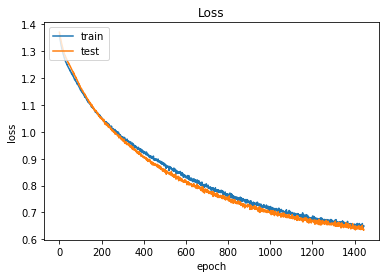

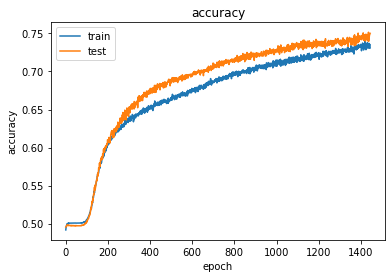

In [293]:
#Plot loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x248676a90>]],
      dtype=object)

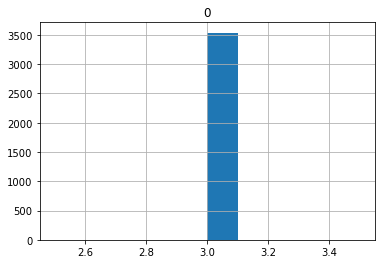

In [294]:
eval_pred_list=[]
for i in range(len(eval_pred)):
    if max(eval_pred[i].astype(int))==1:
        eval_pred_list.append(np.asscalar(np.argwhere(eval_pred[i].astype(int)==1)))
    else:
        eval_pred_list.append(3)
print(cohen_kappa_score(eval_pred_list,eval_labels))
pd.DataFrame(eval_pred_list).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x259255e90>]],
      dtype=object)

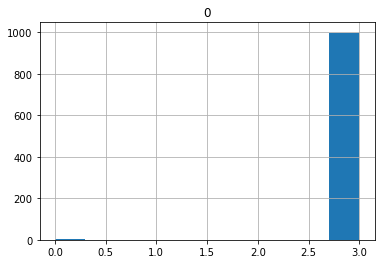

In [295]:
test_pred_list=[]
for i in range(len(test_pred)):
    if max(test_pred[i].astype(int))==1:
        test_pred_list.append(np.asscalar(np.argwhere(test_pred[i].astype(int)==1)))
    else:
        test_pred_list.append(3)
pd.DataFrame(test_pred_list).hist()

##### Conclusion
<br> Tried deep learning with adding different layers and changing other hyperparameters. But
<br> not found any good result. Specially it failed totally to capture any accuracy group other than 
<br> 3. Cohen-Kappa score is also very low. Need different feature engineering to make better prediction.

### Keras regression

In [327]:
%%time
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(64, activation='relu',\
                input_dim=train_features.shape[1]))
model.add(Dense(32, activation='relu'))
#model.add(Dense(24, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
# add output layer
model.add(Dense(1, activation='linear'))



opt=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss="mse", metrics=["mse","mae"])

# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="val_loss", patience=200, verbose=10, mode='auto')

# fit model
result = model.fit(train_features, train_labels, epochs=2000, batch_size=32,\
                   validation_data=(eval_features, eval_labels),callbacks=[earlystopping])
# get predictions
eval_pred = model.predict(eval_features)

test_pred=model.predict(test_features_scaled)

Train on 14152 samples, validate on 3538 samples
Epoch 1/2000
14152/14152 [==============================] - 4s 314us/step - loss: 4.7735 - mse: 4.7735 - mae: 1.8346 - val_loss: 4.3449 - val_mse: 4.3449 - val_mae: 1.7550
Epoch 2/2000
14152/14152 [==============================] - 3s 188us/step - loss: 2.8008 - mse: 2.8008 - mae: 1.4382 - val_loss: 2.1352 - val_mse: 2.1352 - val_mae: 1.2684
Epoch 3/2000
14152/14152 [==============================] - 3s 198us/step - loss: 1.9260 - mse: 1.9260 - mae: 1.1901 - val_loss: 1.8473 - val_mse: 1.8473 - val_mae: 1.1959
Epoch 4/2000
14152/14152 [==============================] - 3s 190us/step - loss: 1.5381 - mse: 1.5381 - mae: 1.0797 - val_loss: 1.4257 - val_mse: 1.4257 - val_mae: 1.0332
Epoch 5/2000
14152/14152 [==============================] - 3s 182us/step - loss: 1.2106 - mse: 1.2106 - mae: 0.9488 - val_loss: 1.2042 - val_mse: 1.2042 - val_mae: 0.9431
Epoch 6/2000
14152/14152 [==============================] - 3s 184us/step - loss: 1.0732 - 

14152/14152 [==============================] - 3s 195us/step - loss: 0.4490 - mse: 0.4490 - mae: 0.4856 - val_loss: 0.5238 - val_mse: 0.5238 - val_mae: 0.5031
Epoch 49/2000
14152/14152 [==============================] - 3s 187us/step - loss: 0.4557 - mse: 0.4557 - mae: 0.4866 - val_loss: 0.5129 - val_mse: 0.5129 - val_mae: 0.5055
Epoch 50/2000
14152/14152 [==============================] - 3s 184us/step - loss: 0.4510 - mse: 0.4510 - mae: 0.4858 - val_loss: 0.4972 - val_mse: 0.4972 - val_mae: 0.4982
Epoch 51/2000
14152/14152 [==============================] - 3s 182us/step - loss: 0.4460 - mse: 0.4460 - mae: 0.4830 - val_loss: 0.5219 - val_mse: 0.5219 - val_mae: 0.5002
Epoch 52/2000
14152/14152 [==============================] - 3s 189us/step - loss: 0.4464 - mse: 0.4464 - mae: 0.4779 - val_loss: 0.4983 - val_mse: 0.4983 - val_mae: 0.4911
Epoch 53/2000
14152/14152 [==============================] - 3s 186us/step - loss: 0.4353 - mse: 0.4353 - mae: 0.4741 - val_loss: 0.5176 - val_mse: 0

14152/14152 [==============================] - 3s 182us/step - loss: 0.3602 - mse: 0.3602 - mae: 0.4066 - val_loss: 0.4440 - val_mse: 0.4440 - val_mae: 0.4309
Epoch 96/2000
14152/14152 [==============================] - 3s 187us/step - loss: 0.3648 - mse: 0.3648 - mae: 0.4087 - val_loss: 0.4572 - val_mse: 0.4572 - val_mae: 0.4272
Epoch 97/2000
14152/14152 [==============================] - 3s 179us/step - loss: 0.3693 - mse: 0.3693 - mae: 0.4118 - val_loss: 0.4404 - val_mse: 0.4404 - val_mae: 0.4269
Epoch 98/2000
14152/14152 [==============================] - 3s 182us/step - loss: 0.3595 - mse: 0.3595 - mae: 0.4069 - val_loss: 0.4505 - val_mse: 0.4505 - val_mae: 0.4275
Epoch 99/2000
14152/14152 [==============================] - 3s 191us/step - loss: 0.3592 - mse: 0.3592 - mae: 0.4066 - val_loss: 0.4451 - val_mse: 0.4451 - val_mae: 0.4257
Epoch 100/2000
14152/14152 [==============================] - 3s 197us/step - loss: 0.3609 - mse: 0.3609 - mae: 0.4078 - val_loss: 0.4526 - val_mse: 

14152/14152 [==============================] - 3s 184us/step - loss: 0.3165 - mse: 0.3165 - mae: 0.3723 - val_loss: 0.4219 - val_mse: 0.4219 - val_mae: 0.3900
Epoch 143/2000
14152/14152 [==============================] - 3s 213us/step - loss: 0.3158 - mse: 0.3158 - mae: 0.3721 - val_loss: 0.4239 - val_mse: 0.4239 - val_mae: 0.3952
Epoch 144/2000
14152/14152 [==============================] - 3s 202us/step - loss: 0.3243 - mse: 0.3243 - mae: 0.3763 - val_loss: 0.3986 - val_mse: 0.3986 - val_mae: 0.3884
Epoch 145/2000
14152/14152 [==============================] - 3s 207us/step - loss: 0.3222 - mse: 0.3222 - mae: 0.3731 - val_loss: 0.4205 - val_mse: 0.4205 - val_mae: 0.3967
Epoch 146/2000
14152/14152 [==============================] - 3s 194us/step - loss: 0.3143 - mse: 0.3143 - mae: 0.3684 - val_loss: 0.4196 - val_mse: 0.4196 - val_mae: 0.3968
Epoch 147/2000
14152/14152 [==============================] - 3s 194us/step - loss: 0.3179 - mse: 0.3179 - mae: 0.3718 - val_loss: 0.4289 - val_m

14152/14152 [==============================] - 3s 191us/step - loss: 0.2926 - mse: 0.2926 - mae: 0.3511 - val_loss: 0.3876 - val_mse: 0.3876 - val_mae: 0.3754
Epoch 190/2000
14152/14152 [==============================] - 3s 183us/step - loss: 0.2918 - mse: 0.2918 - mae: 0.3509 - val_loss: 0.3857 - val_mse: 0.3857 - val_mae: 0.3693
Epoch 191/2000
14152/14152 [==============================] - 3s 191us/step - loss: 0.2920 - mse: 0.2920 - mae: 0.3502 - val_loss: 0.3919 - val_mse: 0.3919 - val_mae: 0.3774
Epoch 192/2000
14152/14152 [==============================] - 3s 192us/step - loss: 0.2948 - mse: 0.2948 - mae: 0.3505 - val_loss: 0.3778 - val_mse: 0.3778 - val_mae: 0.3697
Epoch 193/2000
14152/14152 [==============================] - 3s 193us/step - loss: 0.2930 - mse: 0.2930 - mae: 0.3492 - val_loss: 0.3896 - val_mse: 0.3896 - val_mae: 0.3723
Epoch 194/2000
14152/14152 [==============================] - 3s 200us/step - loss: 0.2918 - mse: 0.2918 - mae: 0.3475 - val_loss: 0.4113 - val_m

14152/14152 [==============================] - 3s 187us/step - loss: 0.2746 - mse: 0.2746 - mae: 0.3325 - val_loss: 0.3997 - val_mse: 0.3997 - val_mae: 0.3701
Epoch 237/2000
14152/14152 [==============================] - 3s 182us/step - loss: 0.2685 - mse: 0.2685 - mae: 0.3327 - val_loss: 0.3961 - val_mse: 0.3961 - val_mae: 0.3686
Epoch 238/2000
14152/14152 [==============================] - 3s 190us/step - loss: 0.2698 - mse: 0.2698 - mae: 0.3312 - val_loss: 0.3878 - val_mse: 0.3878 - val_mae: 0.3652
Epoch 239/2000
14152/14152 [==============================] - 3s 198us/step - loss: 0.2727 - mse: 0.2727 - mae: 0.3335 - val_loss: 0.4028 - val_mse: 0.4028 - val_mae: 0.3679
Epoch 240/2000
14152/14152 [==============================] - 3s 198us/step - loss: 0.2761 - mse: 0.2761 - mae: 0.3356 - val_loss: 0.3976 - val_mse: 0.3976 - val_mae: 0.3732
Epoch 241/2000
14152/14152 [==============================] - 3s 190us/step - loss: 0.2640 - mse: 0.2640 - mae: 0.3298 - val_loss: 0.3922 - val_m

14152/14152 [==============================] - 3s 183us/step - loss: 0.2491 - mse: 0.2491 - mae: 0.3145 - val_loss: 0.3989 - val_mse: 0.3989 - val_mae: 0.3598
Epoch 284/2000
14152/14152 [==============================] - 3s 183us/step - loss: 0.2539 - mse: 0.2539 - mae: 0.3180 - val_loss: 0.3794 - val_mse: 0.3794 - val_mae: 0.3546
Epoch 285/2000
14152/14152 [==============================] - 3s 184us/step - loss: 0.2693 - mse: 0.2693 - mae: 0.3269 - val_loss: 0.4020 - val_mse: 0.4020 - val_mae: 0.3614
Epoch 286/2000
14152/14152 [==============================] - 3s 185us/step - loss: 0.2557 - mse: 0.2557 - mae: 0.3204 - val_loss: 0.3802 - val_mse: 0.3802 - val_mae: 0.3579
Epoch 287/2000
14152/14152 [==============================] - 3s 187us/step - loss: 0.2526 - mse: 0.2526 - mae: 0.3193 - val_loss: 0.3960 - val_mse: 0.3960 - val_mae: 0.3616
Epoch 288/2000
14152/14152 [==============================] - 3s 192us/step - loss: 0.2459 - mse: 0.2459 - mae: 0.3127 - val_loss: 0.4042 - val_m

14152/14152 [==============================] - 3s 184us/step - loss: 0.2394 - mse: 0.2394 - mae: 0.3081 - val_loss: 0.3965 - val_mse: 0.3965 - val_mae: 0.3562
Epoch 331/2000
14152/14152 [==============================] - 3s 185us/step - loss: 0.2266 - mse: 0.2266 - mae: 0.2992 - val_loss: 0.4159 - val_mse: 0.4159 - val_mae: 0.3677
Epoch 332/2000
14152/14152 [==============================] - 3s 187us/step - loss: 0.2429 - mse: 0.2429 - mae: 0.3079 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.3671
Epoch 333/2000
14152/14152 [==============================] - 3s 187us/step - loss: 0.2330 - mse: 0.2330 - mae: 0.3012 - val_loss: 0.3929 - val_mse: 0.3929 - val_mae: 0.3593
Epoch 334/2000
14152/14152 [==============================] - 3s 181us/step - loss: 0.2404 - mse: 0.2404 - mae: 0.3065 - val_loss: 0.4025 - val_mse: 0.4025 - val_mae: 0.3642
Epoch 335/2000
14152/14152 [==============================] - 3s 181us/step - loss: 0.2320 - mse: 0.2320 - mae: 0.3060 - val_loss: 0.4046 - val_m

14152/14152 [==============================] - 3s 196us/step - loss: 0.2400 - mse: 0.2400 - mae: 0.3039 - val_loss: 0.4069 - val_mse: 0.4069 - val_mae: 0.3596
Epoch 378/2000
14152/14152 [==============================] - 3s 196us/step - loss: 0.2154 - mse: 0.2154 - mae: 0.2903 - val_loss: 0.4015 - val_mse: 0.4015 - val_mae: 0.3572
Epoch 379/2000
14152/14152 [==============================] - 3s 192us/step - loss: 0.2277 - mse: 0.2277 - mae: 0.2957 - val_loss: 0.3973 - val_mse: 0.3973 - val_mae: 0.3559
Epoch 380/2000
14152/14152 [==============================] - 3s 193us/step - loss: 0.2224 - mse: 0.2224 - mae: 0.2940 - val_loss: 0.3920 - val_mse: 0.3920 - val_mae: 0.3533
Epoch 381/2000
14152/14152 [==============================] - 3s 180us/step - loss: 0.2292 - mse: 0.2292 - mae: 0.2971 - val_loss: 0.4109 - val_mse: 0.4109 - val_mae: 0.3647
Epoch 382/2000
14152/14152 [==============================] - 3s 185us/step - loss: 0.2212 - mse: 0.2212 - mae: 0.2922 - val_loss: 0.3993 - val_m

14152/14152 [==============================] - 3s 179us/step - loss: 0.2161 - mse: 0.2161 - mae: 0.2873 - val_loss: 0.4088 - val_mse: 0.4088 - val_mae: 0.3553
Epoch 425/2000
14152/14152 [==============================] - 3s 179us/step - loss: 0.2182 - mse: 0.2182 - mae: 0.2889 - val_loss: 0.4067 - val_mse: 0.4067 - val_mae: 0.3562
Epoch 426/2000
14152/14152 [==============================] - 3s 180us/step - loss: 0.2225 - mse: 0.2225 - mae: 0.2901 - val_loss: 0.4037 - val_mse: 0.4037 - val_mae: 0.3520
Epoch 427/2000
14152/14152 [==============================] - 3s 181us/step - loss: 0.2189 - mse: 0.2189 - mae: 0.2876 - val_loss: 0.3875 - val_mse: 0.3875 - val_mae: 0.3495
Epoch 428/2000
14152/14152 [==============================] - 3s 180us/step - loss: 0.2115 - mse: 0.2115 - mae: 0.2850 - val_loss: 0.3964 - val_mse: 0.3964 - val_mae: 0.3586
Epoch 429/2000
14152/14152 [==============================] - 3s 180us/step - loss: 0.2120 - mse: 0.2120 - mae: 0.2856 - val_loss: 0.3931 - val_m

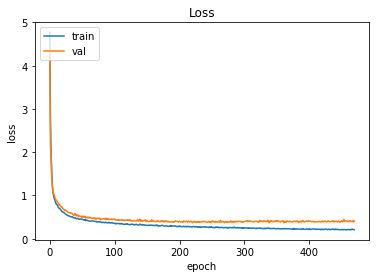

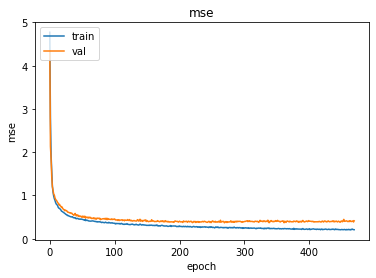

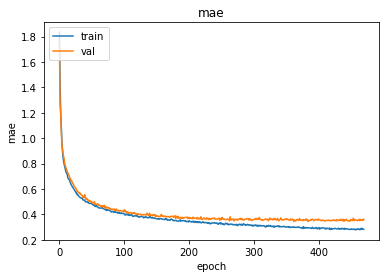

In [328]:
#Plot loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot accuracy
plt.plot(result.history['mse'])
plt.plot(result.history['val_mse'])
plt.title('mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot accuracy
plt.plot(result.history['mae'])
plt.plot(result.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

{0: 0.8950067521758913, 1: 1.9684926439908486, 2: 2.561203360557556}
0.8687379581996866


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b99c4cd0>]],
      dtype=object)

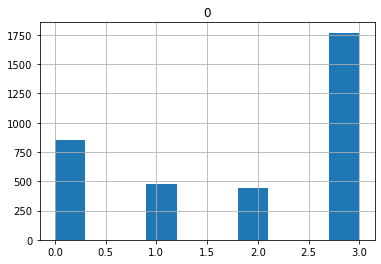

In [329]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(eval_pred)
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
print(cohen_kappa_score(test_class, test_labels, weights = 'quadratic'))
pd.DataFrame(list(test_class)).hist()

{0: 0.01999819092452526, 1: 0.07516937814084339, 2: 0.7311442494392395}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2bad6ff90>]],
      dtype=object)

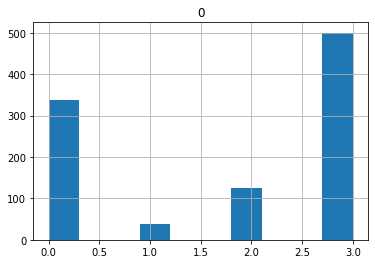

In [330]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(test_pred)
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
pd.DataFrame(list(test_class)).hist()

#### Conclusion - 
<br>Much better class separation can be found after Keras regression and
assigned to classes by distribution<br>